In [1]:
COLAB = 'google.colab' in str(get_ipython())
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd /content/drive/MyDrive/Thesis/

In [5]:
import real_stuff.evaluating as evaluating
import real_stuff.simulating as simulating
import real_stuff.training as training
from real_stuff.basic_imports import *

import importlib  # doesn't do too much in Colab

Situation 6: sampling 5000 X_i ~ 1D uniform. f_k(X) = a normal. K = 5.
X:
 [0.375 0.951 0.732 ... 0.328 0.816 0.597]
Normalized funcs(X) = Y probabilities:
[[0.001 0.172 0.765 0.062 0.   ]
 [0.    0.    0.    0.007 0.993]
 [0.    0.    0.003 0.344 0.653]
 ...
 [0.004 0.356 0.621 0.02  0.   ]
 [0.    0.    0.    0.09  0.91 ]
 [0.    0.    0.112 0.787 0.101]]
Unnormalized funcs(X):
[[4.000e-03 8.700e-01 3.862e+00 3.140e-01 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 9.000e-03 1.281e+00]
 [0.000e+00 0.000e+00 1.600e-02 1.670e+00 3.166e+00]
 ...
 [1.800e-02 1.762e+00 3.075e+00 9.800e-02 0.000e+00]
 [0.000e+00 0.000e+00 1.000e-03 3.890e-01 3.940e+00]
 [0.000e+00 1.000e-03 5.700e-01 3.988e+00 5.110e-01]]
Euclidean distance between those: 198.6761019961408


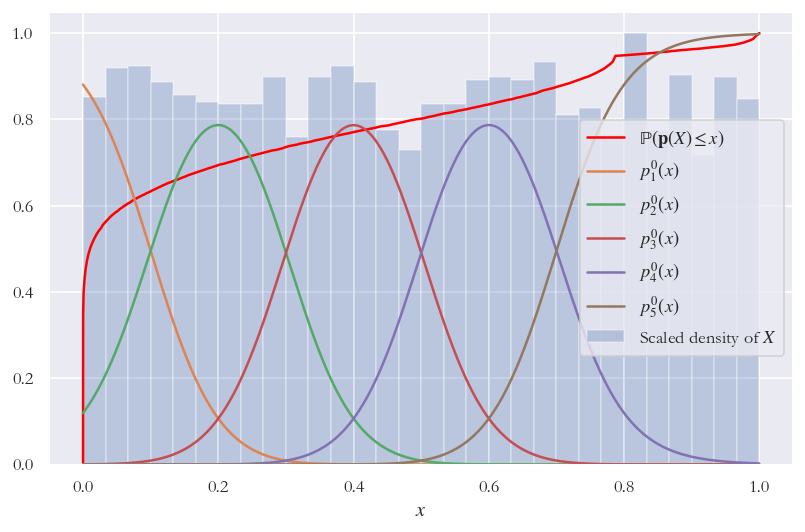

In [6]:
importlib.reload(simulating)
situation = 6.5

X, funcs, Y_prob = simulating.create_dataset(str(situation), n=5000, viz=True)

Max 0/1-accuracy during training: 0.7426
Epoch 1/420
267/267 [==============================] - 1s 3ms/step - loss: 1.5651 - accuracy: 0.3406 - val_loss: 1.3081 - val_accuracy: 0.4638
Epoch 2/420
267/267 [==============================] - 1s 2ms/step - loss: 1.2120 - accuracy: 0.5194 - val_loss: 1.0322 - val_accuracy: 0.5688
Epoch 3/420
267/267 [==============================] - 1s 2ms/step - loss: 1.0720 - accuracy: 0.5638 - val_loss: 0.9453 - val_accuracy: 0.6338
Epoch 4/420
267/267 [==============================] - 1s 2ms/step - loss: 1.0113 - accuracy: 0.5791 - val_loss: 0.8841 - val_accuracy: 0.6300
Epoch 5/420
267/267 [==============================] - 0s 2ms/step - loss: 0.9748 - accuracy: 0.6072 - val_loss: 0.8632 - val_accuracy: 0.6363
Epoch 6/420
267/267 [==============================] - 0s 2ms/step - loss: 0.9341 - accuracy: 0.6291 - val_loss: 0.8209 - val_accuracy: 0.6662
Epoch 7/420
267/267 [==============================] - 0s 2ms/step - loss: 0.9297 - accuracy: 0.6191 

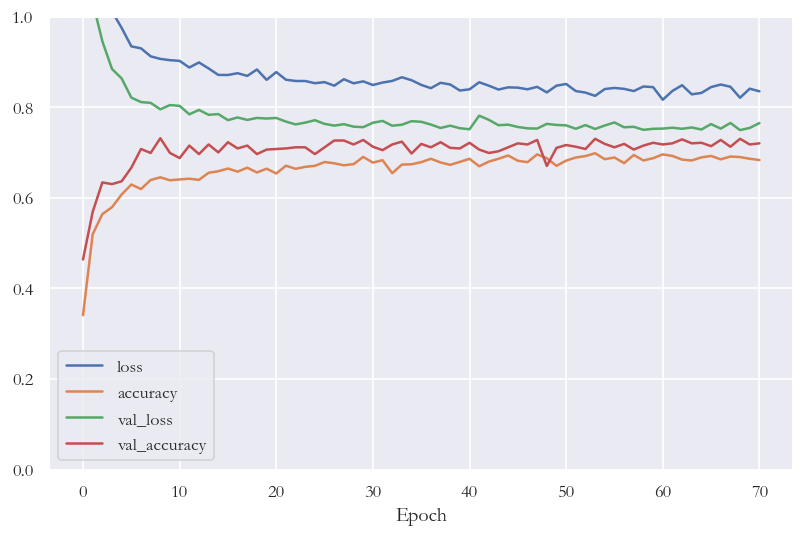

In [7]:
importlib.reload(training)
model, X_test, Y_test, Y_prob_test = training.train_network(X, Y_prob, viz=1)

In [8]:
importlib.reload(evaluating)
evaluating.get_all_quantities_of_interest(model, X_test, Y_test, Y_prob_test)

{'One-hot log-likelihood': 0.60463804,
 'One-hot KL divergence': 0.6046347,
 'Probability vec log-likelihood': 0.60931236,
 'Probability vec KL divergence': 0.030734211,
 'Pr vec KL div truncated (at 0.5)': 0.49999996948242187,
 '~ inf norm diff': 0.37125756712752367,
 'Biases > epsilon': 35,
 'Total biases': 69,
 'Weights > epsilon': 293,
 'Total weights': 864,
 'Epsilon': 0.001,
 's': 328}

Some examples from test set:
X:
[[0.572]
 [0.805]
 [0.76 ]
 ...
 [0.328]
 [0.816]
 [0.597]]
True:
[[0.    0.001 0.18  0.76  0.059]
 [0.    0.    0.    0.108 0.892]
 [0.    0.    0.001 0.231 0.768]
 ...
 [0.004 0.356 0.621 0.02  0.   ]
 [0.    0.    0.    0.09  0.91 ]
 [0.    0.    0.112 0.787 0.101]]
Predict:
[[0.    0.002 0.236 0.649 0.114]
 [0.    0.    0.    0.158 0.842]
 [0.    0.    0.001 0.238 0.762]
 ...
 [0.001 0.373 0.572 0.054 0.   ]
 [0.    0.    0.    0.143 0.857]
 [0.    0.001 0.18  0.671 0.148]]


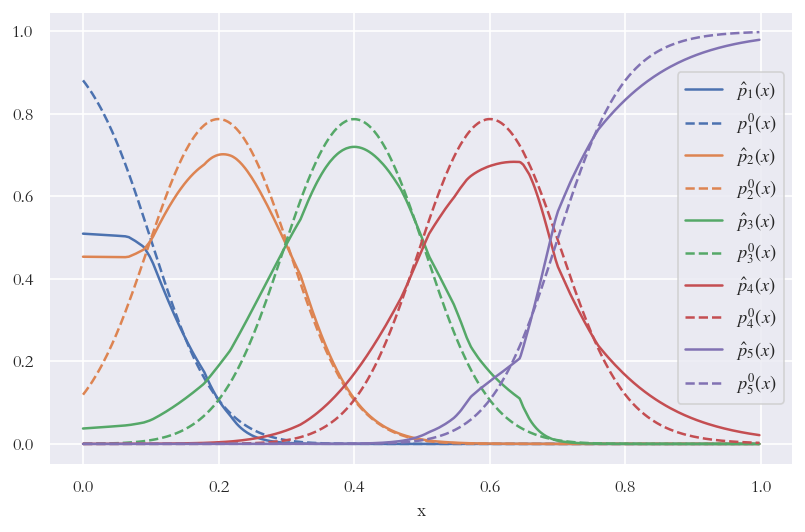

In [9]:
importlib.reload(evaluating)
evaluating.visualize(model, X_test, Y_test, Y_prob_test)

## Temp

In [ ]:
!python test.py 6.2

2.0
{'t^0.2': array([0.1       , 0.10001924, 0.10003847, ..., 0.68399227, 0.68412384,
       0.68425543])}


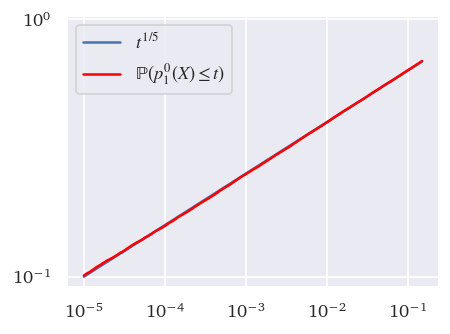

In [40]:
# NOTE: I've destroyed this thing but it's useless anyway

def alpha_C_finder(t_space, p_X_small, alphas):
    # TODO!!
    result = {}
    for alpha in alphas:
        t_alpha = np.power(t_space, alpha)
        C = np.ceil(np.max(p_X_small / t_alpha))
        print(C)
        result[f't^{alpha}'] = t_alpha
    return result


t_space = np.geomspace(1e-5, 0.15, 10_000)
p_X_small = np.array([np.mean(Y_prob[:, 0] <= t) for t in t_space])
alphas = [1 / 5]
results = alpha_C_finder(t_space, p_X_small, alphas)
print(results)

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix",
      "figure.dpi": 120,
      "figure.figsize": [4, 3]
     }
plt.rcParams.update(rc)

for alpha in alphas:
    C_t_alpha = results[f't^{alpha}']

    plt.plot(t_space, C_t_alpha, label="$t^{1/5}$")
    plt.plot(t_space, p_X_small, label="$\mathrm{\mathbb{P}}(p^0_1(X) \leq t)$",
             color="red")
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(top=max(p_X_small) * 1.5)
    plt.savefig("empi.pdf")
    plt.show()

In [ ]:
!python test.py 6.8

In [ ]:
def f1(X, m=30):
#     y = 0
#     for k in range(0, m, 1):
#         y += ((-1)**k)*(X**(1+2*k))/np.math.factorial(1+2*k)
#     return y
    return sum(
        [(-1) ** (i+1) * X ** (2*i-1) / np.math.factorial(2*i-1) for i in range(1, m, 1)]) + .00001


X = np.random.uniform(size=1000)
order = np.argsort(X)
plt.plot(X[order], f1(X[order], 50), color='red')
plt.plot(X[order], np.sin(X[order]), color='blue')
f1(1), np.sin(1)